# Basics of Signal Processing
**Authors**: Anmol Parande, Hoang Nguyen, Jordan Grelling

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd
import scipy.signal as signal

Throughout this notebook, we will be working with a clip from [Suzanne Vega's song, "Tom's Diner"](https://www.youtube.com/watch?v=FLP6QluMlrg). We will use `scipy` to read the audio data from the `.wav` file. It will return the sampling frequency `fs` as well as the audio samples.

In [2]:
fs, audio = wavfile.read("toms-diner.wav")
print(f"Loaded {audio.size} samples at a sampling rate of {fs}Hz")
ipd.Audio(audio, rate=fs)

Loaded 576000 samples at a sampling rate of 48000Hz


# Table of Contents

I. Time Domain Filtering

II. DFT

III. Frequency Domain Filtering

IV. Sampling Theory

V. Spectral Analysis

# I. Time Domain Filtering

A discrete signal can be thought of as a function mapping integers to real values (i.e a function $f: \mathbb{N}\to\mathbb{R})$). This is the so-called "time-domain" representation of the signal because the integers often represent time in some sense.

A system is a process which takes a signal as an input and returns a signal as an output. Digital systems which we use to process signals are called filters. Systems can have several different properties. Two important ones are linearity and time-invariance.

**Linearity**: A system $H$ is linear if given input signal $x$, input signal $y$, and scalars $\alpha$ and $\beta$, $H(\alpha x + \beta y) = \alpha H(x) + \beta H(y)$

**Time-Invariance**: A system is time-invariant when shifting the input signal in time results in an equal shift in time for the output signal (i.e if $H$ transforms $x[n]$ into $y[n]$, then $H$ transforms $x[n-N]$ into $y[n-N]$).

## I.a Linear Filtering

When a system is Linear and Time-Invariant, we can characterize systems by their impulse response. The impulse response of a system $H$ is given by $h[n] = H(\delta[n])$ where $$\delta[n] = \begin{cases} 1 & \text{ if, } n=0\\ 0 & \text{ else.} \end{cases}$$

This is useful because it means we can compute the response of the system by doing a **convolution** of the input with the impulse response.

$$(x * y)[n] = \sum_{k=-\infty}^{\infty}x[k]y[n-k] $$

For example, we can take a moving average by using the filter
$$ h_{avg}[n] = \begin{cases} \frac{1}{5} & \text{ if } 0 \leq n \leq 4\\ 0 & \text{ else.}\end{cases} $$

We can also define a so-called "edge detector" filter in order to detect edges in the audio.
$$ h_{edge}[n] = \begin{cases} (-1)^n & \text{ if } 0 \leq n \leq 1\\ 0 & \text{ else.}\end{cases} $$

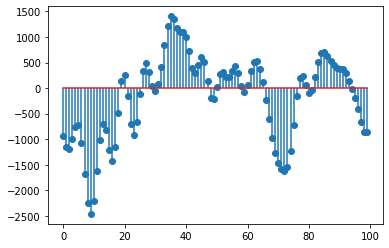

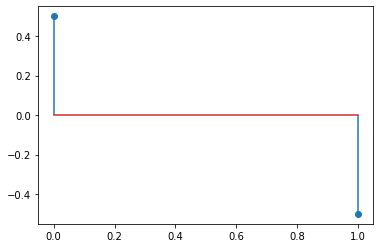

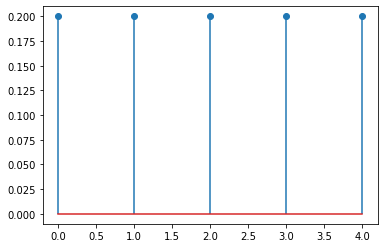

In [3]:
# Edge detector and moving average filters

plt.stem(audio[:100])
plt.show()

hi_pass = np.array([(-1)**n for n in range(2)])/2.0
lo_pass = np.array([1 for n in range(5)])/5.0

plt.stem(hi_pass)
plt.show()

plt.stem(lo_pass)
plt.show()

In [ ]:
plt.stem(np.convolve(audio[:100], hi_pass))
plt.show()

plt.stem(np.convolve(audio[:100], lo_pass))
plt.show()

In [ ]:
hi_pass_song = np.convolve(audio, hi_pass)
ipd.Audio(hi_pass_song, rate=fs)

In [ ]:
hi_pass_song = np.convolve(audio, lo_pass)
ipd.Audio(hi_pass_song, rate=fs)

## I.b Autocorrelation

Cross-correlation, in signal processing terms, is the process of convolving one signal with a flipped version of another. Cross-correlation produces a graph of correlation versus time, where correlation is the dot-product of the two signals at that particular point.
- If you are looking for the timestamps of a particular noise within a longer signal with other sounds present, you may want to cross-correlate the two.
- Cross-correlation is used in sonar to detect when the initial pulse (a known signal) is returned.

Autocorrelation is the practice of cross-correlating a signal with itself. It is helpful for eliminating noise, as true frequencies will be preserved due to being periodic, while noise tends to be reduced.

$$ r_x(n) = x[n] * x[-n] = \sum_{k=-\infty}^{\infty} x[k] x[n-k] $$

In [ ]:
sample = np.sin(2 * np.pi * np.arange(50)/16)
noise = 2*np.random.random(50) - 1
noisy_sample = sample+noise
autocorr = np.convolve(noisy_sample, np.flip(noisy_sample))
plt.stem(noisy_sample)
plt.show()
plt.stem(np.arange(-49,50), autocorr)
plt.show()
# ipd.Audio(audio, rate=fs)

Autocorrelation will always have a peak in the middle, which will grow larger relative to the rest of the signal the more noisy your signal is. However, notice even when the signal is highly corrupted, you can still make out the base frequency in the autocorrelated signal.

## I.c Nonlinear Filtering

Sometimes you end up with a signal that has salt and pepper noise (random bits set to 0 or 1) due to corruption or problems with a sensor. Nonlinear filtering, such as median filtering, applies a non-linear filter so that extremely high peaks made by these errors can be filtered out without disproportionately affecting the surrounding signal.

In [ ]:
salt_and_pepper = np.random.binomial(1, 0.01, size=audio.shape) * 32000 + np.random.binomial(1, 0.01, size=audio.shape) * -32000
audio_corrupted = audio+salt_and_pepper
plt.stem(audio_corrupted[:1000])
plt.show()

In [ ]:
ipd.Audio(audio_corrupted, rate=fs)

In [ ]:
audio_medfilt = signal.medfilt(audio_corrupted, kernel_size=5)

meanfilt = np.array([.2, .2, .2, .2, .2])
audio_meanfilt = np.convolve(audio_corrupted, meanfilt)

In [ ]:
ipd.Audio(audio_medfilt, rate=fs)

# II. DFT

Typically, when we look at signals, we look at them in the so-called time-domain. Each sample $x[k]$ represents the amplitude of the signal at time-step $k$. This tells us what the signal looks like. One question we might want to ask ourselves is _"How fast is the signal changing?"_

For sinusoidal signals like $x[n] = \cos(\omega n)$ and $x[n] = \sin(\omega n)$, answering this question is easy because a larger $\omega$ means the signal is changing faster ($\omega$ is known as the angular frequency). For example, consider the plots below which each consist of 100 samples.

In [ ]:
n = np.linspace(0, 100, 100)
slow_cos = np.cos(2 * np.pi * n / 100)
fast_cos = np.cos(2 * np.pi * 5 * n / 100)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.stem(n, slow_cos, use_line_collection=True)
plt.title("$\cos\\left(\\frac{2\pi}{100} n\\right)$")
plt.subplot(1, 2, 2)
plt.title("$\cos\\left(\\frac{10\pi}{100} n\\right)$")
plt.stem(n, fast_cos, use_line_collection=True)
plt.show()

$\cos\left(\frac{10\pi}{100} t\right)$ is clearly changing a lot faster. If we allow ourselves to consider complex signals, then we can generalized sinusoids using the complex exponential $e^{j\omega}$. Just like real sinusoids, the $\omega$ in the signal $x[n] = e^{j\omega n}$ determines how fast the signal changes (i.e rotates around the unit circle). If we can somehow "project" our time-domain signal $x[n]$ onto a "basis" of complex exponential signals, then, then the coefficients $X[k]$ should tell us how much the signal changes.

The Discrete Fourier Transform is the change of basis which we use for a finite, length-$N$ signal to understand how fast it is changing. The basis used in the DFT are the $N$th roots of unity (i.e the complex solutions to $\omega=1$). More specifically, the $k$th basis vector is given by $\phi_k[n] = e^{j\frac{2\pi}{N}kn}$. Using the complex inner product $\langle \vec{x}, \vec{y} \rangle = \vec{y}^*\vec{x}$, the DFT coefficients are given by

$$X[k] = \langle x, \phi_k \rangle = \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi}{N}kn}.$$

From the DFT coefficients, we can recover the time-domain coefficients using the inverse DFT.

$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1}X[k]e^{j\frac{2\pi}{N}kn}.$$

There are many ways to compute the DFT. The fastest method is the Fast Fourier Transform (FFT), which is an algorithm which computes the DFT. It is built into `numpy` as part of the `fft` submodule.

If we look at the DFT coefficients of the two cosines we saw earlier, we can see that it is indeed doing exactly what we wanted it to: characterizing the frequency of the signal.

In [ ]:
slow_cos_fft = np.fft.fft(slow_cos)
fast_cos_fft = np.fft.fft(fast_cos)

plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.stem(n, np.abs(slow_cos_fft), use_line_collection=True)
plt.title("$|DFT\{\cos\\left(\\frac{2\pi}{100} n\\right)\}|$")
plt.subplot(2, 2, 2)
plt.title("$|DFT\{\cos\\left(\\frac{10\pi}{100} n\\right)\}|$")
plt.stem(n, np.abs(fast_cos_fft), use_line_collection=True)
plt.subplot(2, 2, 3)
plt.stem(n, np.angle(slow_cos_fft), use_line_collection=True)
plt.title("$\\arg \\left(DFT\{\cos\\left(\\frac{2\pi}{100} n\\right)\}\\right)$")
plt.subplot(2, 2, 4)
plt.title("$\\arg \\left(DFT\{\cos\\left(\\frac{10\pi}{100} n\\right)\}\\right)$")
plt.stem(n, np.angle(fast_cos_fft), use_line_collection=True)
plt.show()

Since $\cos\left(\frac{2\pi}{100}n\right) = \frac{1}{2}\left(e^{j\frac{2\pi}{100}n} + e^{-j\frac{2\pi}{100}n}\right)$, we should expect peaks at $k = 1$ and $k =-1$ (note that because the roots of unity are periodic, $k=-1$ is the same basis vector as $k=99$). Likewise, since $\cos\left(\frac{10\pi}{100}n\right) = \frac{1}{2}\left(e^{j\frac{10\pi}{100}n} + e^{-j\frac{10\pi}{100}n}\right)$, we should expect peaks at $k=5$ and $k=-5$.

There are a few things to note:
1. The DFT coefficients are complex numbers, so we need both magnitude (top plots) and phase (bottom plots) to characterize the signal information
2. For both $\cos\left(\frac{2\pi}{100}n\right)$ and $\cos\left(\frac{10\pi}{100}n\right)$, we should only expect 2 non-zero coefficients. However, we have apparently many non-zero coefficients. These are due to numerical instability in the FFT algorithm (if you print them out, these coefficients are on the order of $10^{-3}$ in magnitude and so are insignificant).
3. The DFT basis is **not** orthonormal. This is why we must scale by $\frac{1}{N}$ when applying the inverse DFT (`np.fft.ifft` in numpy). This is also why the peak magnitudes of the example signals above are 50 and not $\frac{1}{2}$.
4. DFT basis vectors are complex conjugates of each other (i.e $\phi_k[n] = \phi_{N-k}[n]^*$). This means for real signals, $X[k] = X^*[N-k]$.

### Exercise

To get a better feel for the DFT, compute and plot the magnitude of the DFT coefficients of our clip from Tom's Diner in decibels ($dB = 20\log_{10}(\cdot)$). Since our song is a real signal, do not plot the complex conjugate coefficients since they are redundant information.

In [ ]:
plt.figure(figsize=(15, 7))

# ** YOUR CODE HERE ** #
song_dft = 20 * np.log10(np.abs(np.fft.fft(audio)))
plt.plot(song_dft[:audio.size // 2]) # Coefficents N/2 to N are complex coefficients
plt.show()

**Comprehension Question**: Do you notice anything interesting about the chart above?

**Answer**: Around index 150,000, there is a sharp decline in the magnitude of the DFT coefficients. It turns out that this DFT coefficient represents approximately 12.5 kHz (we'll see how to compute this later), which is close to the human hearing limit of about 20kHz.

**Comprehension Question**: What does the first coefficient $X[0]$ of the DFT represent in simple terms?

**Answer**: It is the sum of the signal (we can see this from the formula by letting $k=0$).

## II.a PSD

In signal processing, due to noise, numerical stability, and other issues, we often care about the dominant frequencies in the signal (e.g when we are looking for formants in a vowel). This means we want to look at the magnitude of the DFT coefficients. However, sometimes peaks in the DFT are difficult to distinguish when looking at a magnitude plot. To better distinguish peaks, we can instead look at $|X[k]|^2$, the so-called **Power Spectral Density (PSD)**.

The Power Spectral Density is the essentially the magnitude of the DFT of the auto-correlation of the signal $x$. This is because when $x[n]$ has DFT coefficients $X[k]$, then $x[-n]$ has DFT coefficients $X^*[k]$ and since auto-correlation is the convolution of $x[n] * x[-n]$, and convolution in the time-domain is multiplication in the frequency domain, $PSD = X[k] X^*[k] = |X[k]|^2$.

### Exercise

Use the PSD to guess what vowels these are. Use the `n` argument of the DFT function to zero-pad the signal so that you compute the same number of DFT coefficients for each vowel.

In [ ]:
vowel_1 = audio[int(7.3 * fs):int(fs * 7.325)] * np.hanning(0.025 * fs)
vowel_2 = audio[int(11.6 * fs):int(11.625 * fs)] * np.hanning(0.025 * fs)
freqs = np.linspace(0, fs, 12000)

In [ ]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)

# ** YOUR CODE HERE ** #
vowel_1_dft = np.abs(np.fft.fft(vowel_1, n=12000)) ** 2
plt.plot(freqs[:800], vowel_1_dft[:800]) # Coefficents N/2 to N are complex coefficients

plt.subplot(2, 1, 2)
# ** YOUR CODE HERE ** #
vowel_2_dft = np.abs(np.fft.fft(vowel_2, n=12000)) ** 2
plt.plot(freqs[:800], vowel_2_dft[:800]) # Coefficents N/2 to N are complex coefficients

plt.show()

Listen to the audio and see if you were right!

In [ ]:
ipd.Audio(vowel_1, rate=fs)

In [ ]:
ipd.Audio(vowel_2, rate=fs)

# III. Frequency Domain Filtering

One really nice property of the DFT is that convolution in the time domain is equivalent to multiplication in the frequency domain, and convolution in frequency is equivalent to multiplication in time.
- Important implications to sampling theory, which will be covered in the next section
- Makes convolution much more efficient: convolution in time on long signals of length n is $O(n^2)$, while converting to frequency domain, multiplying, and converting back is $O(n \log{n})$
- Makes it easy to control what frequencies you filter. If you want a high-pass filter with a specific cutoff for example, or a band-pass filter to only capture F0, you can design the filter in the frequency domain and then convert it back to the time domain!


#### The Frequency Response

Just like any signal in the time domain can be transformed into the frequency domain, so can every filter. For every impulse response $h[n]$ in the time domain, we can calculate $H[k]$ in the frequency domain by performing the DFT. Since multiplication in the frequency domain is equivalent to convolution in time, we can actually uniquely characterize any LTI filter $H$ by its impulse response or frequency response. Oftentimes, it is easier to design filters in the frequency domain. For example, in speech recognition where the signal is easily separable by formant in the frequency domain, and we want to design a filter that captures speech while ignoring other frequencies. We don't much care what the shape of the filter is in the time domain, so we can design a filter in the frequency domain and impose restrictions on it to create the filter we need.

#### Types of Filters

Highpass filters let high frequencies through, while blocking low frequencies. This kind of filter is used to filter out low frequency background interference from power lines or machinery.

Lowpass filters let low frequencies through, while blocking high frequencies. This kind of filter is often used to reduce high frequency noise, or eliminate aliasing from downsampling.

Bandpass/bandstop filters pass or block only a specific range of frequencies. This might be useful in audio processing for focusing solely on F1 or F2, for example.

In [ ]:
audio_fft = np.fft.fft(audio)
len_clip = audio.shape[0]
cutoff_frequency = 500 * len_clip/fs

freq_filter = np.array([1 if n < cutoff_frequency else 0 for n in range(len_clip)])
time_filter = np.real(np.fft.ifft(freq_filter))
audio_fft = np.fft.fft(audio)
audio_filtered = np.real(np.fft.ifft(audio_fft*freq_filter))

plt.plot(audio[:1000])
plt.show()

plt.plot(freq_filter[:44100], color='r')
plt.show()

plt.plot(audio_filtered[:1000])
plt.show()

We can also design filters in the frequency domain to optimize for specific conditions, rather than simply using a box filter in the frequency domain (which has drawbacks, as we'll see later). One example of such a filter is the Butterworth Filter, which is designed to minimize variation in the frequency response in the passband, and thus avoid distortions in the output signal.

The Butterworth filter has 3 main parameters:

- **N**, the order of the filter: how sharp the cutoff is

- $\boldsymbol{\omega_h}$, the cutoff frequency: the frequency at which the frequency response drops to $1/\sqrt{2}$ of the passband response

- **btype**, the type of filter (ie, lowpass, highpass, bandpass, bandstop)

Documentation can be found at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter

In [ ]:
sos = signal.butter(2, 500, 'hp', fs=fs, output='sos')
audio_filtered = signal.sosfilt(sos, audio)
b, a = signal.butter(2, 500, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)), color='r')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(500, color='green') # cutoff frequency
plt.show()

In [ ]:
ipd.Audio(audio_filtered, rate=fs)

# IV. Sampling Theory

In the real-world, most signals are continuous (i.e they are functions from $\mathbb{R}\to\mathbb{R}$). Meanwhile, computers operate in the discrete space (i.e they are functions from $\mathbb{N}\to\mathbb{R}$. This means that in order to analyze any continuous signal, we need to somehow discretize it so it can be stored in finite memory.

Given a continuous signal $x_c(t)$, we can obtain a discrete signal by letting $x_d[n] = x_c(f(n))$ where $f: \mathbb{N}\to\mathbb{R}$ describes our sampling scheme.

A **uniform, non-adaptive sampling** scheme is where we pick some sampling frequency $\omega_s$ and let $f(n) = \frac{n}{\omega_s}$. We can think of it as "saving" the value of the continuous time signal every $\frac{1}{\omega_s}$ seconds. _Uniform_ means that $\omega_s$ is constant (i.e it does not depend on $n$), and _non-adaptive_ means $\omega_s$ is independent of the samples we have seen so far. Uniform, non-adaptive sampling schemes are what we most frequently use for sampling because of their simplicity and well-known theoeretical guarantees. For the rest of the notebook, we will assume all sampling is uniform and non-adaptive.

Because sampling has the potential to destroy information, we need to understand how it impacts the frequency domain. In continuous time, frequencies exist on the range $[0, \infty)$. However, in discrete time, the fastest that a signal can change is $\pi$ radians / sample (i.e alternating from 1 to -1 like $\cos(\pi n)$). When we take the DFT of a signal that we sampled, we want to know how our angular frequencies relate to the continuous frequencies.

The easiest way to think of how continuous frequencies relate to discrete frequencies is by mapping the interval $\left[0, \frac{f_s}{2}\right]$ (continuous frequencies) to the interval $[0, \pi]$ (angular frequencies). Given an angular frequency $\omega_d\in[0, \pi]$, the continuous frequency that it represent $\omega_c = \frac{f_s}{2\pi}\omega_d$.

### Exercise
Plot the magnitude of DFT coefficients (in decibels) of our clip from Tom's Diner and label the x-axis with the continuous time frequencies. Ignore the complex conjugate coefficients.

In [ ]:
plt.figure(figsize=(15, 7))

# ** YOUR CODE HERE ** #
freqs = np.linspace(0, fs / 2, audio.size // 2)
song_dft = 20 * np.log10(np.abs(np.fft.fft(audio)))
plt.plot(freqs, song_dft[:audio.size // 2]) # Coefficents N/2 to N are complex coefficients
plt.xlabel("Hz")
plt.show()

## IV.a Aliasing

How frequently we sample matters a lot. If we sample too slowly, then we lose information. If we sample too fast, then we are wasting memory. The three plots below are all samples of a 10 second long sine wave $x(t) = \sin(2\pi t)$.

In [ ]:
hundred_hz = np.linspace(0, 10, 1000)
ten_hz = np.linspace(0, 10, 100)
one_hz = np.linspace(0, 10, 10)

plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.plot(one_hz, np.sin(2 * np.pi * one_hz))
plt.title("$f_s$ = 1Hz")

plt.subplot(1, 3, 2)
plt.plot(ten_hz, np.sin(2 * np.pi * ten_hz))
plt.title("$f_s$ = 10Hz")

plt.subplot(1, 3, 3)
plt.plot(hundred_hz, np.sin(2 * np.pi * hundred_hz))
plt.title("$f_s$ = 100Hz")

plt.show()

Notice how the faster sampling frequencies 10Hz and 100Hz look virtually identical and cycle 10 times in 10 seconds as we expect a 1Hz sine wave to do. However, when we sample at 1Hz, our samples look like they came from a 0.1Hz sine wave, not a 1Hz sine wave. When higher frequencies "masquerade" as lower frequencies, this is known as **aliasing**. The effects of aliasing are very clear in the frequency domain through the following example where we sample the signal $x_c(t) = \sin(2\pi t) + \sin(2\pi * 10t)$ with a sampling frequency of 11Hz vs a sampling frequency of 50Hz vs a sampling frequency of 1000Hz over the course of 1 second.


In [ ]:
def x_c(t):
    return np.sin(2 * np.pi * t) + np.sin(2 * np.pi * 10 * t)

eleven_hz = np.linspace(0, 1, 11)
fifty_hz = np.linspace(0, 1, 50)
thousand_hz = np.linspace(0, 1, 1000)

plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
plt.plot(eleven_hz, x_c(eleven_hz))
plt.title("$f_s$ = 11Hz (Time Domain)")

plt.subplot(3, 3, 2)
plt.plot(fifty_hz, x_c(fifty_hz))
plt.title("$f_s$ = 50Hz (Time Domain)")

plt.subplot(3, 3, 3)
plt.plot(thousand_hz, x_c(thousand_hz))
plt.title("$f_s$ = 1000Hz (Time Domain)")

plt.subplot(3, 3, 4)
plt.plot(np.linspace(0, 11, eleven_hz.size), np.abs(np.fft.fft(x_c(eleven_hz))))
plt.title("$f_s$ = 11Hz (Frequency Domain)")
plt.xlabel("Hz")

plt.subplot(3, 3, 5)
plt.plot(np.linspace(0, 50, fifty_hz.size), np.abs(np.fft.fft(x_c(fifty_hz))))
plt.title("$f_s$ = 50Hz (Frequency Domain)")
plt.xlabel("Hz")

plt.subplot(3, 3, 6)
plt.plot(np.linspace(0, 1000, thousand_hz.size), np.abs(np.fft.fft(x_c(thousand_hz))))
plt.title("$f_s$ = 1000Hz (Frequency Domain)")
plt.xlabel("Hz")

plt.show()

When we sampled at 50Hz, we had 2 very clear frequencies in our spectrum. However, at 11Hz, the second peak disappeared entirely! We can think of it as "hiding" in the 1Hz peak in the spectrum. At 1000Hz, we can measure a much larger range of frequencies, and so all of our peaks remain in the plot (they look squished together due to the scale of the axis).

The **Nyquist Theorem** tells us how fast we need to sample in order to prevent aliasing. It states that in order to avoid aliasing, our sampling frequency $f_s$ must be at least twice the highest frequency present in the signal ($f_s > 2 * f_{max}$). In practice, due to noise, there is no maximum frequency of the signal, so we always have some aliasing. This can be minimized by using an analog anti-aliasing filter before we sample. Note that the Nyquist theorem holds in discrete time as well. Namely, if we want to downsample a recording, then the most we can sample is by a factor of $M$ (i.e take every Mth sample) such that $\frac{\pi}{M} > 2 * \omega_{max}$.

### Exercise
How much can we downsample our audio clip before aliasing starts to degrade our audio quality? Which parts of the audio degrade first (hint, think about which frequencies are masked).

In [ ]:
two_downsampled = audio[::2]
ipd.Audio(two_downsampled, rate=fs // 2)

In [ ]:
four_downsampled = audio[::4]
ipd.Audio(four_downsampled, rate=fs // 4)

In [ ]:
eight_downsampled = audio[::8]
ipd.Audio(eight_downsampled, rate=fs // 8)

In [ ]:
sixteen_downsampled = audio[::16]
ipd.Audio(sixteen_downsampled, rate=fs // 16)

## IV.b Quantization

Earlier, we allowed our discrete signals to be functions from $\mathbb{N}\to\mathbb{R}$. In words, we discretized time, but our signal took values over a continuous range. This is not entirely accurate since computers require use bits to represent numbers, so if we use $B$ bits to represent the values our signal takes on, we can only represent $2^B$ possible values.

### Exercise
See how changing the number of bits we use to represent audio impacts the quality of the audio (currently using 16bits)

In [ ]:
ipd.Audio(audio // 4096, rate=fs)

# V. Spectral Analysis - Hoang

## V.a Windowing

**Why?**
* We can only capture a finite length of a signal
* Impossible to capture an infinitely long signal (x[n] from $n = -\infty$ to $n = \infty$

**How?**
* Time domain: Multiple the signal x[n] with a window: $x[n] \cdot w[n]$
* Frequency domain: Convolution between the spectrum and the DTFT of the window, thus blurring the spectrum

$$x[n] w[n] \stackrel{\mathcal{FT}}{\Leftrightarrow} \frac{1}{2\pi} \int_{-\pi}^{\pi} X(e^{ju}) W(e^{j(\omega-u)}) \,du$$

**Important note**
* Rectangular window has the best resolution but the most leakage 
    * Never use this due to excessive sidelobe leakage outweight the resolution gain
* Popular window: Hann, Hamming, Tukey, Blackman, etc.
    * Not applying one of these windows == rectangular window by default
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f2/Window_functions_in_the_frequency_domain.png" alt="Spectrum of different window functions" width="600"/>

## V.b STFT/Spectrogram Overview

**Overview**

<img src="./Images/STFT_steps.png" alt="Step-by-step to perform STFT" width="700"/>

**Data window duration tradeoff**

|     Data Window Duration    |     Frequency Resolution    |     Time Resolution    |     PSD Bias    |     PSD Variance    |
|:---------------------------:|:---------------------------:|:----------------------:|:---------------:|:-------------------:|
|             Long            |             High            |           Low          |        Low      |         High        |
|             Short           |              Low            |           High         |       High      |          Low        |


**Step size/Overlap tradeoff**
* Small step size (more overlaps between segments of the signal) yeilds better resolution but consumes more computation power

In [ ]:
clipped_audio = audio[:len(audio)//2]   # clip the audio in half for better visibility
Tw_s = 0.01                             # data window duration (seconds)
Tw = int(np.round(Tw_s * fs))           # data window duration (samples)
no = Tw//1.01                           # number of overlaps
N = clipped_audio.size                  # number of samples
Tmax = N/fs                             # duration of recording

print(f'Window duration (seconds): {Tw_s} seconds out of {Tmax} seconds')
print(f'Window duration (samples): {Tw} samples out of {clipped_audio.size} samples')
print(f'Number of overlaps: Overlapping {no} samples out of {Tw} samples')

f, t, Spectrogram = scipy.signal.spectrogram(x=clipped_audio, fs=fs, window='blackman', nperseg=Tw, noverlap=no, nfft=Tw)

plt.figure(figsize=(15,7))
plt.pcolormesh(t, f, np.log10(Spectrogram))
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 15000)
plt.xlabel('Time (sec)')
plt.show()

# V.c Spectral Estimation Methods
 
**Periodogram**
* Has excessive variance

**Blackman-Tukey**
* Reduce variance by smoothing the periodogram
* Window the autocorrelation before taking the PSD
* Autocorrelation window duration to control the tradeoff between PSD bias and variance

<img src="./Images/autocorrelation_window_duration_tradeoff.png" alt="Autocorrelation window duration tradeoff" width="250"/>

**Welch-Bartlett**
* Reduce variance by averaging the periodogram

## V.d Summary: Important Spectral Analysis Tradeoffs

|      Spectrogram Design Parameters     |                              Tradeoffs                             |
|:--------------------------------------:|:------------------------------------------------------------------:|
|               Window types             |      Frequency resolution (mainlobe width) vs. Sidelobe leakage    |
|           Data window duration         |     Frequency resolution vs. Time resolution; Bias vs. Variance    |
|            Step size/Overlap           |                   Computation power vs. Resolution                 |
|     Autocorrelation window duration    |                          Bias vs. Variance                         |


# Resources

1. [Anmol's Course Notes from EE120 (Signals and Systems)](https://aparande.gitbook.io/berkeley-notes/ee120-0)
2. [Anmol's Course Notes from EE123 (Digital Signal Processing)](https://aparande.gitbook.io/berkeley-notes/ee123-0)
3. [Discrete Time Signal Formula Sheet](https://anmolparande.com/resources/berkeley/discrete-formula-sheet.pdf)